notebook creates plots for rank analysis of switch targets (reward rank, uncertainty rank)

In [1]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
import ptitprince as pt
import seaborn as sns
import pdb 


In [2]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [3]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD\\p1_generalization'

# Define functions

In [4]:
# function to get counter-based uncertainty of actions

def get_uncertainty(choices, n_trials = 300, n_actions = 4):

    unc = np.zeros([n_trials, n_actions])

    for t in range(n_trials):
        for a in range(n_actions):
            if np.array(choices!=a)[t]:
                unc[t,a] = unc[t-1,a]+1
            else:
                unc[t,a] =  0
    return(unc)

In [5]:
### get rank of running reward (rank_rr) as function of choices & rewards

def get_rank_rr(choices, rewards, n_actions = 4):
    
    #####################
    # running reward
    #####################

    '''
    running reward is the last observed reward of a given action
    '''
    
    n_trials = len(choices)
    
    # get is_switch
    is_switch = [int(choices[t] != choices[t-1]) for t in range(1, n_trials)]
    is_switch = np.append(0, is_switch)
    is_switch = is_switch == 1

    # create running reward array
    run_rew = np.zeros([n_trials, n_actions])

    for a in range(N_ACTIONS):

        for t in range(n_trials):
            if np.array(choices==a)[t]:
                # if action is chosen update running reward
                run_rew[t, a] = rewards[t, a]
            else:
                # if not chosen running reward of an action remains unchanged
                run_rew[t, a] = run_rew[t-1, a]

    # get shifted running reward (as running reward t-1 informs action t)
    shifted_run_rew = np.zeros([n_trials, n_actions])
    for a in range(n_actions):
        shifted_run_rew[:, a] = np.array(pd.Series(run_rew[:,a]).shift(1))

    # get chosen shifted running reward (running reward t-1 of action t)
    chosen_shifted_run_rew = np.array([shifted_run_rew[t,a] for t, a in enumerate(choices)])


    # drop running reward of previous choice and current choice
    prev_choice = pd.Series(choices).shift(1).values
    shifted_run_rew_at_switch = shifted_run_rew[is_switch] 
    shifted_run_rew_other_at_switch = np.zeros([np.sum(is_switch), 2])
    # changed from 1 to 0
    for t in range(0, len(prev_choice[is_switch])):
        shifted_run_rew_other_at_switch[t,:] = np.delete(shifted_run_rew_at_switch[t,:],
                                           [int(prev_choice[is_switch][t]),
                                            int(choices[is_switch][t])])

    # run rew of switch target on 0 index
    chosen_rr_st = np.reshape(chosen_shifted_run_rew[is_switch], [-1,1])
    # concetenate uncertainty of switch target at index 0 and other on index 1 and 2
    cleaned_rr = np.hstack([chosen_rr_st, shifted_run_rew_other_at_switch])
    # rank uncertainty with bindings to average
    ranked_rr = np.array([rankdata(cleaned_rr[row,:], method = 'average')-1 for row in range(np.shape(cleaned_rr)[0])])
    # get mean rew rank rank at switch
    mean_rr_rank = np.mean(ranked_rr[:,0])
    
    return mean_rr_rank

In [6]:
### get rank of mean rank of uncertainty count as a function of choices
def get_rank_unc(choices, n_actions = 4):
    
    # for predicted choices, excluded implausible value range
    choices = choices[choices>=0]

    n_trials = len(choices)

    # get is_switch
    is_switch = [int(choices[t] != choices[t-1]) for t in range(1, n_trials)]
    is_switch = np.append(0, is_switch)
    is_switch = is_switch == 1

    # get uncertainty
    unc = get_uncertainty(choices, n_trials)
    
    # shift uncertainty (as uncertainty before a switch is relevant)
    shifted_unc = np.zeros_like(unc)
    for a in range(4):
        shifted_unc[:, a] = np.array(pd.Series(unc[:,a]).shift(1))
        
    # get chosen shifted uncertainty
    chosen_shifted_unc = np.array([shifted_unc[t,a] for t, a in enumerate(choices)])

    # drop uncertainty of previous choice and current choice
    prev_choice = pd.Series(choices).shift(1).values
    shifted_unc_at_switch = shifted_unc[is_switch] 
    shifted_unc_other_at_switch = np.zeros([np.sum(is_switch), 2])
    
    # range starts at 0 instead of 1
    for t in range(0, len(prev_choice[is_switch])):
        shifted_unc_other_at_switch[t,:] = np.delete(shifted_unc_at_switch[t,:],
                                           [int(prev_choice[is_switch][t]),
                                            int(choices[is_switch][t])])

    # uncertainty of switch target on 0 index
    chosen_unc_st = np.reshape(chosen_shifted_unc[is_switch], [-1,1])
    # concetenate uncertainty of switch target at index 0 and other on index 1 and 2
    cleaned_unc = np.hstack([chosen_unc_st, shifted_unc_other_at_switch])
    # rank uncertainty with bindings to average
    ranked_unc = np.array([rankdata(cleaned_unc[row,:], method = 'average')-1 for row in range(np.shape(cleaned_unc)[0])])
    # get mean uncertainty rank at switch
    mean_unc_rank = np.mean(ranked_unc[:,0])
    
    return mean_unc_rank

# Human data

In [7]:
PATH_DATA ='data/human_raw_data/'
FILE_NAME = 'data_chakroun_wiehler.csv'

N_ACTIONS = 4

NUM_IDS = 31

In [8]:
### Human Data

rank_rr_human = []
rank_unc_human = []

for id_ in range(1, NUM_IDS+1):

    # load human file
    df = pd.read_csv(os.path.join(PATH_DATA, FILE_NAME), index_col=0)
    # filter human file
    df1 = df[np.logical_and(df.vp==id_, df.study=='chakroun')]
    # choices are zero indexed
    choices = df1.choice.to_numpy() -1
    # delete omitted choices
    omit = np.where(choices == -1)
    choices = np.delete(choices, omit)
    # get rewards from bandit walks
    rewards = np.array(df1.loc[:, [col.startswith('reward_b') for col in df1.columns.values]])
    # delete rewards of omitted choices
    rewards = np.delete(rewards, [omit], axis = 0)
    
    # get mean reward rank
    rr = get_rank_rr(choices, rewards)
    
    # get mean uncertainty rank
    unc = get_rank_unc(choices)
    
    
    # append mean rr rank
    rank_rr_human.extend([rr])
    # append uncertainty rank
    rank_unc_human.extend([unc])


# RNN data

In [9]:
### RNN Data

PATH_DATA ='data/rnn_raw_data/'
FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

N_ACTIONS = 4

NUM_IDS = 30
N_WALKS = 3

In [10]:
rank_rr_rnn = []
rank_unc_rnn = []

for id_ in range(NUM_IDS):
    for w in range(1,N_WALKS+1):
        
        # get data from RNN instance
        d = pickle.load(open(os.path.join(PATH_DATA, FILE_NAME.format(id_, w)), 'rb'))
        df = d.reset_index()
        choices = df.choice.to_numpy()
        # get rewards from bandit walks
        rewards = np.array(df.loc[:, [col.startswith('p_rew') for col in df.columns.values]])
        # get mean reward rank
        rr = get_rank_rr(choices, rewards)
        # get mean uncertainty rank
        unc = get_rank_unc(choices)
        # append mean rr rank
        rank_rr_rnn.extend([rr])
        # append uncertainty rank
        rank_unc_rnn.extend([unc])

# Plotting

In [11]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['axes.grid'] = True

In [12]:
# half violin plots

def grouped_half_violin_plot(plot_df, note1 = 'more uncertain',
                             note2 = 'less uncertain',
                             note_col = 'black',
                             ylabel = 'Mean uncertainty rank of switch targets',
                             group1 = 'RNN',
                             group2 = 'Human'):
    
    f, ax = plt.subplots()
    dy="vals"
    dx = "group"
    ort="v"
    pal = {group1: "lightblue", group2: "grey"}

    ax=pt.half_violinplot(y = dy, x = dx, data = plot_df, bw = .2, cut = 0.,palette = pal,
                          scale = "area", width = .6, inner = None, orient = ort, alpha = 0.3)

    pal1 = {group1: "blue", group2: "black"}
    ax=sns.stripplot(y = dy, x = dx, data = plot_df, edgecolor = "white",palette = pal1,
    size = 7, jitter = 1, zorder = 0, orient = ort, alpha = 0.2)

    x=sns.boxplot(y = dy, x = dx, data = plot_df, color = note_col, width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
    showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
    saturation = 1, orient = ort)

#     plt.hlines(1, xmin = -0.5, xmax = 1.5, color = note_col, linewidth = 3, linestyles = '--')
#     plt.annotate(note1, xy = [0.22,1.02], size = 14, color = note_col)
#     plt.annotate(note2, xy = [0.22,0.96], size = 14, color = note_col)
#     plt.annotate('', xy=(0.17, 1.08),
#                  xycoords='data',
#                  #xytext=(0.17, 1.01),
#                  xytext=(0.17, 1.01),
#                  textcoords='data',
#                  arrowprops=dict(
#                                  color=note_col,
#                                  lw=1)
#                )

#     plt.annotate('', xy=(0.17, 0.92),
#                  xycoords='data',
#                  xytext=(0.17, 0.99),
#                  textcoords='data',
#                  arrowprops=dict(
#                                  color=note_col,
#                                  lw=1)
#                )

    plt.ylabel(ylabel)
    plt.xlabel('')

## Uncertainty rank

In [13]:
plot_df = pd.DataFrame({'vals': rank_unc_human + rank_unc_rnn,
              'group':['Human']*len(rank_unc_human)+(['RNN']*len(rank_unc_rnn))})

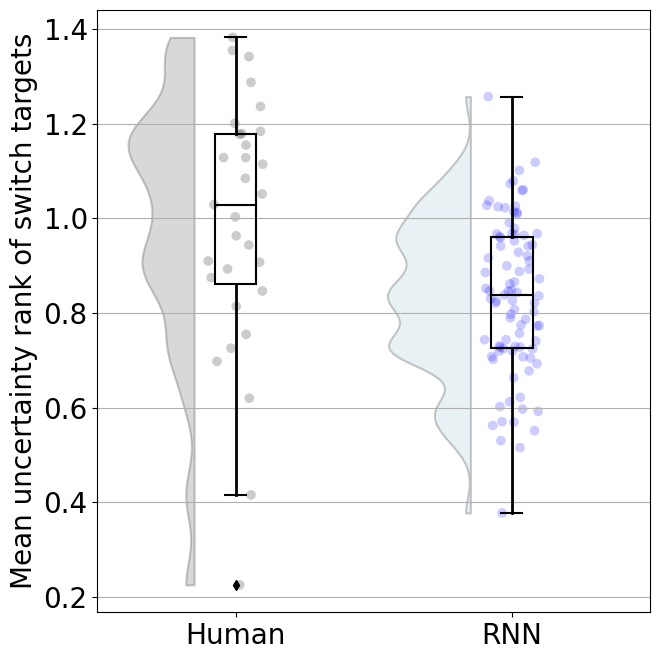

In [14]:
grouped_half_violin_plot(plot_df)

plt.tight_layout()

plt.savefig('../p1_generalization/plots/{}.png'.format('fig_6_grouped_A'), dpi = 600)


## Running reward rank

In [15]:
plot_df = pd.DataFrame({'vals': rank_rr_human + rank_rr_rnn,
              'group':['Human']*len(rank_rr_human)+(['RNN']*len(rank_rr_rnn))})

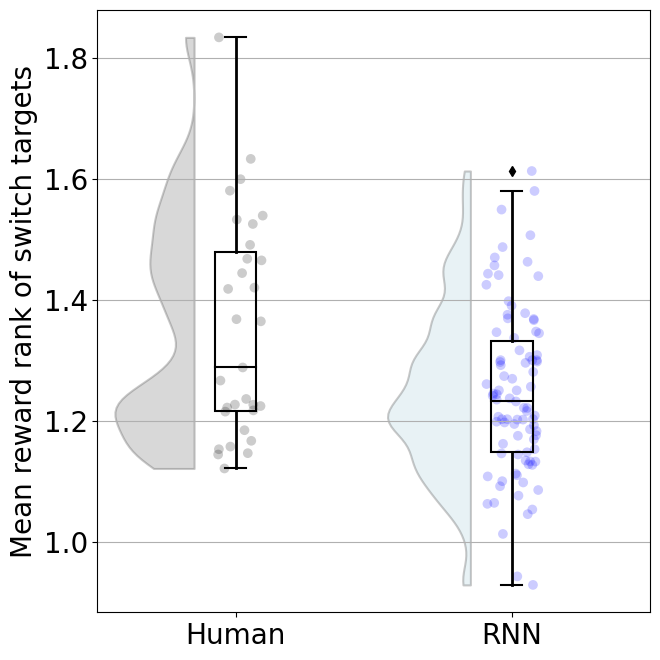

In [16]:
grouped_half_violin_plot(plot_df, note1 = 'more rewarding',
                             note2 = 'less rewarding',
                             note_col = 'black',
                             ylabel = 'Mean reward rank of switch targets' )

plt.tight_layout()

plt.savefig('../p1_generalization/plots/{}.png'.format('fig_6_grouped_B'), dpi = 600)

# Save Data for JASP

In [17]:
jasp_df = pd.DataFrame({'rank_rr': rank_rr_human + rank_rr_rnn,
                        'rank_unc':rank_unc_human + rank_unc_rnn,
                        'group':['Human']*len(rank_rr_human)+(['RNN']*len(rank_rr_rnn))})

In [18]:
jasp_df.to_csv('./data/intermediate_data/jasp_analysis/rank_switch_target_analysis.csv')

# Cut

In [19]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['axes.grid'] = True

In [20]:
def my_violin_plot(ydata, ylabel, plot_name, note1 = '', note2 = ''):
    # create plot df
    plot_df = pd.DataFrame({"accuracy": ydata
                           })

    # half violin plots
    f, ax = plt.subplots()
    dy="accuracy"; ort="v"; 

    ax=pt.half_violinplot(y = dy, data = plot_df, bw = .2, cut = 0.,
                          scale = "area", width = .6, inner = None, orient = ort)

    ax=sns.stripplot(y = dy, data = plot_df, edgecolor = "white",
    size = 7, jitter = 1, zorder = 0, orient = ort, alpha = 0.8)

    x=sns.boxplot(y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
    showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
    saturation = 1, orient = ort)
    
    plt.hlines(1, xmin = -0.5, xmax = 0.5, color = 'lightgreen', linewidth = 3, linestyles = '--')
    plt.annotate(note1, xy = [0.2,1.02], size = 14, color = 'lightgreen')
    plt.annotate(note2, xy = [0.2,0.97], size = 14, color = 'lightgreen')
    plt.annotate('', xy=(0.17, 1.05),
                 xycoords='data',
                 xytext=(0.17, 1.01),
                 textcoords='data',
                 arrowprops=dict(
                                 color='lightgreen',
                                 lw=1)
               )

    plt.annotate('', xy=(0.17, 0.95),
                 xycoords='data',
                 xytext=(0.17, 0.99),
                 textcoords='data',
                 arrowprops=dict(
                                 color='lightgreen',
                                 lw=1)
               )

    plt.ylabel(ylabel)
    plt.xlabel('')

    plt.tight_layout()
    
    plt.savefig('../p1_generalization/plots/{}.png'.format(plot_name), dpi = 600)
    

In [ ]:
my_violin_plot(ydata=rank_rr_human, ylabel='Mean reward rank of switch targets',
               note1='more rewarding',
               note2='less rewarding',
              plot_name = 'fig_6_C_Human')

In [ ]:
my_violin_plot(ydata=rank_unc_human, ylabel='Mean uncertainty rank of switch targets',
               note1='more uncertain',
               note2='less uncertain',
              plot_name = 'fig_6_D_Human')

# posterior predictive checks

In [17]:
rnn_ppred_choices = np.load('data/intermediate_data/modeling/rnn_ppred_choices.npy')
human_ppred_choices = np.load('data/intermediate_data/modeling/human_ppred_choices.npy')

In [18]:
ppred_rank_unc_rnn = []
for i in range(np.shape(rnn_ppred_choices)[1]):
    x = rnn_ppred_choices[:,i,:]-1
    x = x.astype(int)
    ppred_rank_unc_rnn.extend([np.mean(np.apply_along_axis(get_rank_unc, 1, x))])

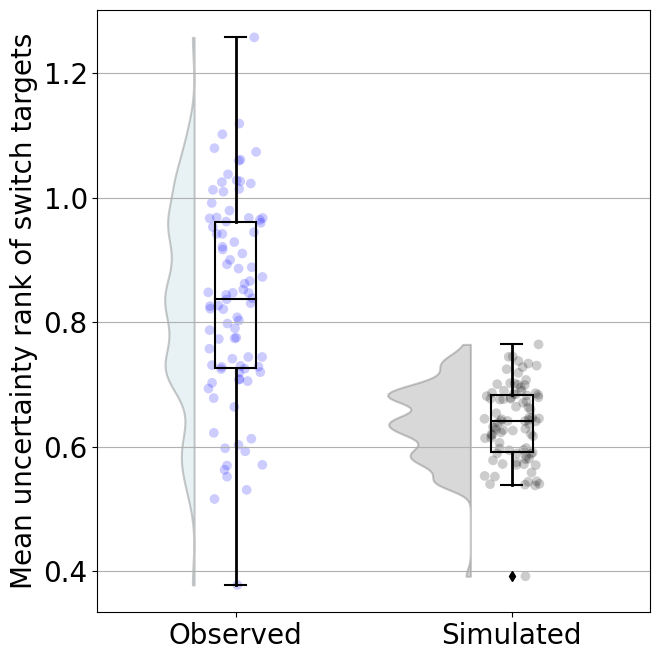

In [23]:
plot_df = pd.DataFrame({'vals': rank_unc_rnn + ppred_rank_unc_rnn,
              'group':['Observed']*len(rank_unc_rnn)+(['Simulated']*len(ppred_rank_unc_rnn))})

grouped_half_violin_plot(plot_df, note1 = 'more uncertain',
                         note2 = 'less uncertain',
                         note_col = 'black',
                         ylabel = 'Mean uncertainty rank of switch targets',
                         group1='Observed',
                         group2='Simulated'
                        )

plt.tight_layout()

plt.savefig('../p1_generalization/plots/{}.png'.format('fig_6_unc_ppred_rnn'), dpi = 600)

In [ ]:
ppred_rank_unc_human = []
for i in range(0, 31):
    x = human_ppred_choices[:,i,:]-1
    x = x.astype(int)
    ppred_rank_unc_human.extend([np.mean(np.apply_along_axis(get_rank_unc, 1, x))])

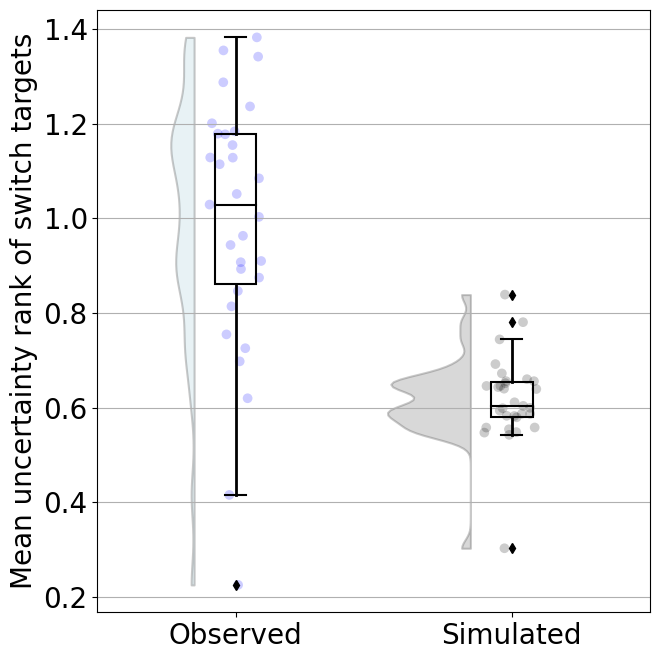

In [24]:
plot_df = pd.DataFrame({'vals': rank_unc_human + ppred_rank_unc_human,
              'group':['Observed']*len(rank_unc_human)+(['Simulated']*len(ppred_rank_unc_human))})

grouped_half_violin_plot(plot_df, note1 = 'more uncertain',
                         note2 = 'less uncertain',
                         note_col = 'black',
                         ylabel = 'Mean uncertainty rank of switch targets',
                         group1='Observed',
                         group2='Simulated'
                        )

plt.tight_layout()

plt.savefig('../p1_generalization/plots/{}.png'.format('fig_6_unc_ppred_human'), dpi = 600)